# 05. Linking Reddit and BBC Good Food

In [9]:
import requests               
import pandas as pd          
import numpy as np
from scrapy import Selector  
from tqdm import tqdm
import spacy
import sys
from plotnine import *
import altair as alt

# Import our own modules
sys.path.append("../scripts/")
import chadtools

In [2]:
bbclink = 'https://www.bbcgoodfood.com/search?q='
response = requests.get(bbclink)
sel = Selector(text=response.text)
links = []

recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
links.extend(recipecards)  
prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

In [3]:
base_url = 'https://www.bbcgoodfood.com/search?q=&limit=1000&page='

links = []
for i in tqdm(range(1, 11)):
    response = requests.get(base_url + str(i))
    sel = Selector(text = response.text)
    recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
    links.extend(recipecards)  

prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

len(final_links)

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [02:20<00:35, 17.59s/it]


KeyboardInterrupt: 

### Create a DataFrame containing the nutritional data of all the recipes on BBCGoodFood 

In [ ]:
session = requests.Session()

def get_nutrition(url):
    response2 = session.get(url)
    sel2 = Selector(text=response2.text)
    table = sel2.css('table.key-value-blocks.hidden-print.mt-xxs')
    bbc = {}
    bbc['bbcgf_title'] = sel2.css('h1.heading-1 ::text').get()
    bbc['calories'] = table.css('td.key-value-blocks__value ::text').get()
    bbc['salt'] = table.xpath('.//*[contains(text(), "salt")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['fat'] = table.xpath('.//*[contains(text(), "fat")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['sugars'] = table.xpath('.//*[contains(text(), "sugars")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['saturates'] = table.xpath('.//*[contains(text(), "saturates")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['carbs'] = table.xpath('.//*[contains(text(), "carbs")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['protein'] = table.xpath('.//*[contains(text(), "protein")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['fibre'] = table.xpath('.//*[contains(text(), "fibre")]/..').css('td.key-value-blocks__value ::text').get()
    bbc['bbcgf_ratings_raw'] = sel2.css("div.rating__values span.sr-only ::text").get()
    return bbc

bbc = [get_nutrition(url) for url in tqdm(final_links)]

df_bbc = pd.DataFrame(bbc)
df_bbc['bbcgf_ratings'] = df_bbc['bbcgf_ratings_raw'].str.extract(r'(\d+\.\d+)').astype(float) / 5.0 
df_bbc.head(10)

100%|██████████| 10011/10011 [2:31:43<00:00,  1.10it/s] 


,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings_raw,bbcgf_ratings
0,Chicken & chorizo jambalaya,445,1.2,10,7,3,64,30,2,A star rating of 4.8 out of 5.,0.96
1,Lemon drizzle cake,399,0.3,21,33,13,50,5,1,A star rating of 4.7 out of 5.,0.94
2,Chilli con carne recipe,387,2.32,17,1,6,25,36,6,A star rating of 4.8 out of 5.,0.96
3,Best ever chocolate brownies recipe,150,0.1,9,12,5,15,2,1,A star rating of 4.8 out of 5.,0.96
4,Creamy courgette lasagne,405,1.36,21,13,8,38,18,4,A star rating of 4.6 out of 5.,0.92
5,Classic Victoria sandwich recipe,558,0.9,28,57,17,76,5,0.6,A star rating of 4.5 out of 5.,0.90
6,Classic Christmas cake,678,0.6,29,79,12,88,9,3,A star rating of 4.7 out of 5.,0.94
7,Chicken noodle soup,217,2.5,2,1,0.4,26,26,0.6,A star rating of 4.8 out of 5.,0.96
8,Easy chocolate fudge cake,608,0.7,33,52,11,69,7,2,A star rating of 4.7 out of 5.,0.94
9,Sweet potato & peanut curry,387,0.6,25,15,18,32,6,7,A star rating of 4.7 out of 5.,0.94


### Save the data as a CSV file 

In [ ]:
df_bbc.to_csv('../data/bbc_data.csv', index=False)

Save the data as HTML for webpage

In [ ]:
df_bbc.head().to_html('../docs/bbc_data.html')

### Read cleaned_posts.json and bbc_data.csv

In [ ]:
df_filtered = pd.read_json('../data/cleaned_posts_with_ingredient_list.json', orient='records')
df_filtered.tail()

,id,title,gpt_ingredients,ingredient_comment_truncated,score,upvote_ratio,link_flair_text,author,created_utc,url,permalink
993,jhi1cz,Vegetarian Pumpkin Meatballs with a Heart of C...,"[pumpkin, parmigiano, breadcrumbs, egg, assort...",\n\nHere another recipe with pumpkin!! A deli...,54,0.890137,Fruit\Vegetarian,italian_cook,1603581735000,https://www.reddit.com/gallery/jhi1cz,https://reddit.com/r/recipes/comments/jhi1cz/v...
994,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,"[oil, bitter gourd, onion, green chillies, cur...",Recipe.....\n\n[Short Video](https://youtu.be/...,6,0.620117,Fruit\Vegetarian,PassionateHobbies,1602879492000,https://i.redd.it/bpootodgbit51.jpg,https://reddit.com/r/recipes/comments/jcgb7j/b...
995,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,"[olive oil, eggplant, carrots, celery, onion, ...",Ingredients:\n\n* 7 Tablespoons olive oil\n* 1...,22,0.830078,Fruit\Vegetarian,BrinaElka,1600970345000,https://i.redd.it/l7osuhkcm4p51.jpg,https://reddit.com/r/recipes/comments/iz12pg/o...
996,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,"[2 teaspoons neutral oil for frying, 2 tablesp...",**Recipe here originally:** [**Easy Mushroom B...,2693,0.979980,Fruit\Vegetarian,BushyEyes,1600565227000,https://i.redd.it/511qxuct57o51.jpg,https://reddit.com/r/recipes/comments/iw3wli/m...
997,isunwt,Easy Tomato Risotto with Parmesan,"[tomato risotto, ripe tomatoes, garlic, extra ...",**Recipe here originally:** [**Easy Tomato Ris...,1796,0.990234,Fruit\Vegetarian,BushyEyes,1600122747000,https://i.redd.it/0qb76yy3m6n51.jpg,https://reddit.com/r/recipes/comments/isunwt/e...


In [6]:
df_bbc = pd.read_csv('../data/bbc_data.csv')
df_bbc.head()

,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings_raw,bbcgf_ratings
0,Chicken & chorizo jambalaya,445.0,1.20,10.0,7.0,3.0,64.0,30.0,2.0,A star rating of 4.8 out of 5.,0.96
1,Lemon drizzle cake,399.0,0.30,21.0,33.0,13.0,50.0,5.0,1.0,A star rating of 4.7 out of 5.,0.94
2,Chilli con carne recipe,387.0,2.32,17.0,1.0,6.0,25.0,36.0,6.0,A star rating of 4.8 out of 5.,0.96
3,Best ever chocolate brownies recipe,150.0,0.10,9.0,12.0,5.0,15.0,2.0,1.0,A star rating of 4.8 out of 5.,0.96
4,Creamy courgette lasagne,405.0,1.36,21.0,13.0,8.0,38.0,18.0,4.0,A star rating of 4.6 out of 5.,0.92


In [7]:
df_bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10011 entries, 0 to 10010
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bbcgf_title        10009 non-null  object 
 1   calories           9951 non-null   float64
 2   salt               9942 non-null   float64
 3   fat                9949 non-null   float64
 4   sugars             9950 non-null   float64
 5   saturates          9950 non-null   float64
 6   carbs              9951 non-null   float64
 7   protein            9950 non-null   float64
 8   fibre              9946 non-null   float64
 9   bbcgf_ratings_raw  10008 non-null  object 
 10  bbcgf_ratings      7740 non-null   float64
dtypes: float64(9), object(2)
memory usage: 860.4+ KB


Save the data as HTML for webpage

In [5]:
df_bbc.head().to_html('../docs/bbc_data.html')

In [10]:
len(df_filtered)

NameError: name 'df_filtered' is not defined

## Calculating cosine similarity and merging columns based on the maximum similarity 

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

df_reddit = df_filtered.copy()
df_reddit = df_reddit.drop('ingredient_comment_truncated', axis=1)

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
similarity_threshold = 0.75
merge_columns = ['bbcgf_title', 'calories', 'salt', 'fat', 'sugars', 'saturates', 'carbs', 'protein', 'fibre', 'bbcgf_ratings']

# Encode titles using Sentence Transformer
embeddings_reddit = model.encode(df_reddit['title'].tolist())
embeddings_bbc = model.encode(df_bbc['bbcgf_title'].tolist())

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_reddit, embeddings_bbc)

# Find the indices and values of the maximum similarity in each row
max_similarity_indices = cosine_sim_matrix.argmax(axis=1)
max_similarity_values = cosine_sim_matrix.max(axis=1)

# Mask indices where the similarity is below the threshold
mask = max_similarity_values > similarity_threshold

# Merge columns based on the max similarity
df_reddit.loc[mask, merge_columns] = df_bbc.iloc[max_similarity_indices[mask]][merge_columns].values

df_reddit.tail()

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
df_reddit.to_json('../data/merged_data.json', orient='records', indent=4)

for easy ref for now, can delete later 

In [14]:
selected_columns = ['title', 'upvote_ratio', 'bbcgf_title', 'calories', 'salt', 'fat', 'sugars', 'saturates', 'carbs', 'protein', 'fibre', 'bbcgf_ratings']
df_selected = df_reddit[selected_columns]
df_selected.tail(15)

,title,upvote_ratio,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
983,Beetroot risotto with creamy goat cheese,0.979980,Beetroot risotto with feta,727.0,1.90,24.0,19.0,9.0,93.0,22.0,8.0,0.96
984,Tunisian inspired chickpeas,0.899902,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
985,Simple Spanakopita (spinach pie),0.979980,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
986,Black Bean Veggie Dip,0.970215,Avocado & cannellini bean dip,194.0,0.30,14.0,1.0,2.0,10.0,5.0,5.0,0.90
987,Chilli Non-Carne With Roasted Peppers,0.970215,Smoky chilli con carne,395.0,1.00,23.0,7.0,8.0,17.0,27.0,7.0,0.96
988,"Green shakshuka with spinach, parsley, articho...",0.990234,Green shakshuka with harissa & crispy shallots,410.0,1.20,27.0,11.0,8.0,16.0,23.0,8.0,0.96
989,Sweet and tangy pineapple and cucumber pickle,0.979980,Pickled pineapple & sriracha grilled cheese,1118.0,4.40,75.0,23.0,29.0,74.0,3.0,5.0,0.96
990,Apple-Cheddar Grilled Cheese Sandwiches with T...,0.890137,Cider & onion soup with cheese & apple toasts,523.0,2.30,31.0,16.0,19.0,40.0,14.0,6.0,0.94
991,Easy Miso Fried Rice!,0.979980,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,Onigirazu with Okra &amp; Smoked Tofu,0.990234,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Produce a dataframe for analysis by dropping rows with no nutrition data 

In [15]:
df_for_analysis = df_reddit.dropna(subset=merge_columns, how='any')
df_for_analysis.info()

NameError: name 'merge_columns' is not defined

In [ ]:
df_for_analysis.head()

,id,title,gpt_ingredients,score,upvote_ratio,link_flair_text,author,created_utc,url,permalink,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
0,1ah8m5s,Thai Green Curry Chicken Satay,"[chicken satay, homemade green curry paste, ve...",41,0.870117,Recipe,butchec,1706893611000,https://i.redd.it/g5xtfz2ve7gc1.jpeg,https://reddit.com/r/recipes/comments/1ah8m5s/...,Thai green chicken curry,257.0,0.60,15.0,3.0,10.0,9.0,19.0,2.0,0.90
1,1afoma3,Sweet and Sour Tofu,"[tofu, ground black pepper, salt, cornstarch, ...",54,0.890137,Recipe,parisrosaries,1706725321000,https://i.redd.it/9nhm0k2mitfc1.jpeg,https://reddit.com/r/recipes/comments/1afoma3/...,Sweet & sour tofu,530.0,1.20,17.0,18.0,2.0,75.0,15.0,8.0,0.82
5,1acagoz,Chocolate Fudgy Brownie,"[butter, dark chocolate, cocoa powder, white s...",113,0.910156,Recipe,butchec,1706360858000,https://i.redd.it/uoqw1lapezec1.jpeg,https://reddit.com/r/recipes/comments/1acagoz/...,Fudgy brownies,1043.0,0.62,62.0,76.0,35.0,105.0,14.0,6.0,0.86
8,19d0wfc,Buffalo Chicken Tenders,"[chicken tenderloins, flour, garlic powder, eg...",267,0.970215,Recipe,BushyEyes,1705944195000,https://i.redd.it/qtwisr8gz0ec1.jpeg,https://reddit.com/r/recipes/comments/19d0wfc/...,Buffalo chicken,520.0,7.40,35.0,11.0,15.0,11.0,39.0,3.0,0.88
9,1998zka,Prawn Katsu Baos,"[kewpie, plain yoghurt, dill pickles, capers, ...",287,0.950195,Recipe,TheLuckiestDragon,1705528588000,https://i.redd.it/q81uyef4o2dc1.jpeg,https://reddit.com/r/recipes/comments/1998zka/...,Prawn katsu burgers,1070.0,2.80,74.0,13.0,12.0,68.0,30.0,6.0,0.90


In [ ]:
df_for_analysis.to_csv('../data/merged_data_for_analysis.csv', index=False)

In [ ]:
df_for_analysis.to_json('../data/merged_data_for_analysis.json', orient='records', indent=4)

Saving as html for website

In [19]:
df_for_analysis.head().to_html('../docs/merged_data_for_analysis.html')

## Analysis of merged Reddit and BBC Good Food data

### Plotting histograms of BBC Good Food ratings against each flair 
Having obtained the user ratings from BBC Good Food, we can compare if there are any differences between the category of foods that are popular amongst Reddit vs BBC Good Food users. 

In [18]:
df_for_analysis = pd.read_json('../data/merged_data_for_analysis.json', orient='records')

In [ ]:
df_desserts = df_for_analysis[df_for_analysis['link_flair_text']=='Dessert']
df_recipe = df_for_analysis[df_for_analysis['link_flair_text']=='Recipe']
df_pasta = df_for_analysis[df_for_analysis['link_flair_text']=='Pasta']
df_poultry = df_for_analysis[df_for_analysis['link_flair_text']=='Poultry']
df_drink = df_for_analysis[df_for_analysis['link_flair_text']=='Drink']
df_beef = df_for_analysis[df_for_analysis['link_flair_text']=='Beef']
df_pork = df_for_analysis[df_for_analysis['link_flair_text']=='Pork']
df_seafood = df_for_analysis[df_for_analysis['link_flair_text']=='Seafood']
df_fruitveg = df_for_analysis[df_for_analysis['link_flair_text']=='Fruit\Vegetarian']

In [ ]:
# plot a histogram of the bbc ratings for each flair category
flair_names = ['Dessert', 'Recipe', 'Pasta', 'Poultry', 'Drink', 'Beef', 'Pork', 'Seafood', 'Fruit\Vegetarian']

for flair in flair_names:
    plot = (
        ggplot(df_for_analysis[df_for_analysis["link_flair_text"] == flair], aes(x='bbcgf_ratings')) + 
        geom_histogram(binwidth=0.01, fill='#5c3da4') +
        themes.theme_matplotlib() + 
        ggtitle(f"Frequency of {flair} posts by BBC Good Food ratings ratio") +
        themes.theme(plot_title = element_text(weight='bold', color="black")) +
        themes.theme(aspect_ratio=9/16)
    )

    plot.save(f"../plots/{flair}_hist.png".replace("\\", ""), dpi=300) 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Dessert_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Recipe_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Pasta_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Poultry_hist.png
/Users/

In [ ]:
# Sort by 'upvote ratio' in descending order
df_sorted = df_for_analysis.sort_values(by='bbcgf_ratings', ascending=False)

# Calculate the number of rows for the top 10%
top_10_percent = int(0.1 * len(df_sorted))

# Take the top 10% of the DataFrame
top_10_df = df_sorted.head(top_10_percent)

ordered_flair_list = top_10_df['link_flair_text'].value_counts().index.tolist()
# Plot a bar graph showing the number of posts from different flairs
plot = ggplot(top_10_df, aes(x="link_flair_text")) + \
       geom_bar(fill='#5c3da4') + \
       coord_flip() + \
       ggtitle("Top 10% of posts by BBC Good Food ratings") + \
       scale_x_discrete(limits=top_10_df["link_flair_text"].value_counts().index.tolist()[::-1]) + \
       themes.theme(plot_title = element_text(weight='bold', color="black")) + \
       themes.theme(aspect_ratio=9/16)


plot.save(f"../plots/plot_top_10_percent_bbcgf.jpg", format="jpg", dpi=600)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/plot_top_10_percent_bbcgf.jpg


### Plotting an interactive scatter plot of calories against upvote ratio

For easier visualisation, combine the 'Poultry', 'Beef', 'Pork', 'Seafood' flairs into one flair titled 'Meats'.

In [ ]:
df_for_altair = df_for_analysis.copy()

df_for_altair['link_flair_text'].replace(['Poultry', 'Beef', 'Pork', 'Seafood'], 'Meats', inplace=True)


In [ ]:
x_scale = alt.Scale(domain=(0.5, 1))
colour_scale = alt.Scale(domain=['Dessert', 'Recipe', 'Pasta', 'Meats', 'Drink', 'Fruit\\Vegetarian'],
                         range=['#41afaa', '#466eb4', '#00a0e1', '#e6a532', '#d7642c', '#af4b91'])

selection = alt.selection_point(fields=['link_flair_text'], bind='legend')

scatter = alt.Chart(df_for_altair, width=800, height=600).mark_circle().encode(
    x=alt.X('upvote_ratio:Q', scale=x_scale, title='Upvote Ratio'),
    y=alt.Y('calories:Q', title='Calories'), 
    color=alt.Color('link_flair_text:N', scale=colour_scale, legend=alt.Legend(title='Flair')),
    tooltip=['title:N', 'upvote_ratio:Q', 'calories:Q', 'link_flair_text:N'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.15))
).add_params(
    selection
).interactive()

scatter.save('../docs/interactive_plot.html', scale_factor=2.0)


In [ ]:
scatter

alt.Chart(...)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 84 rows containing missing values.


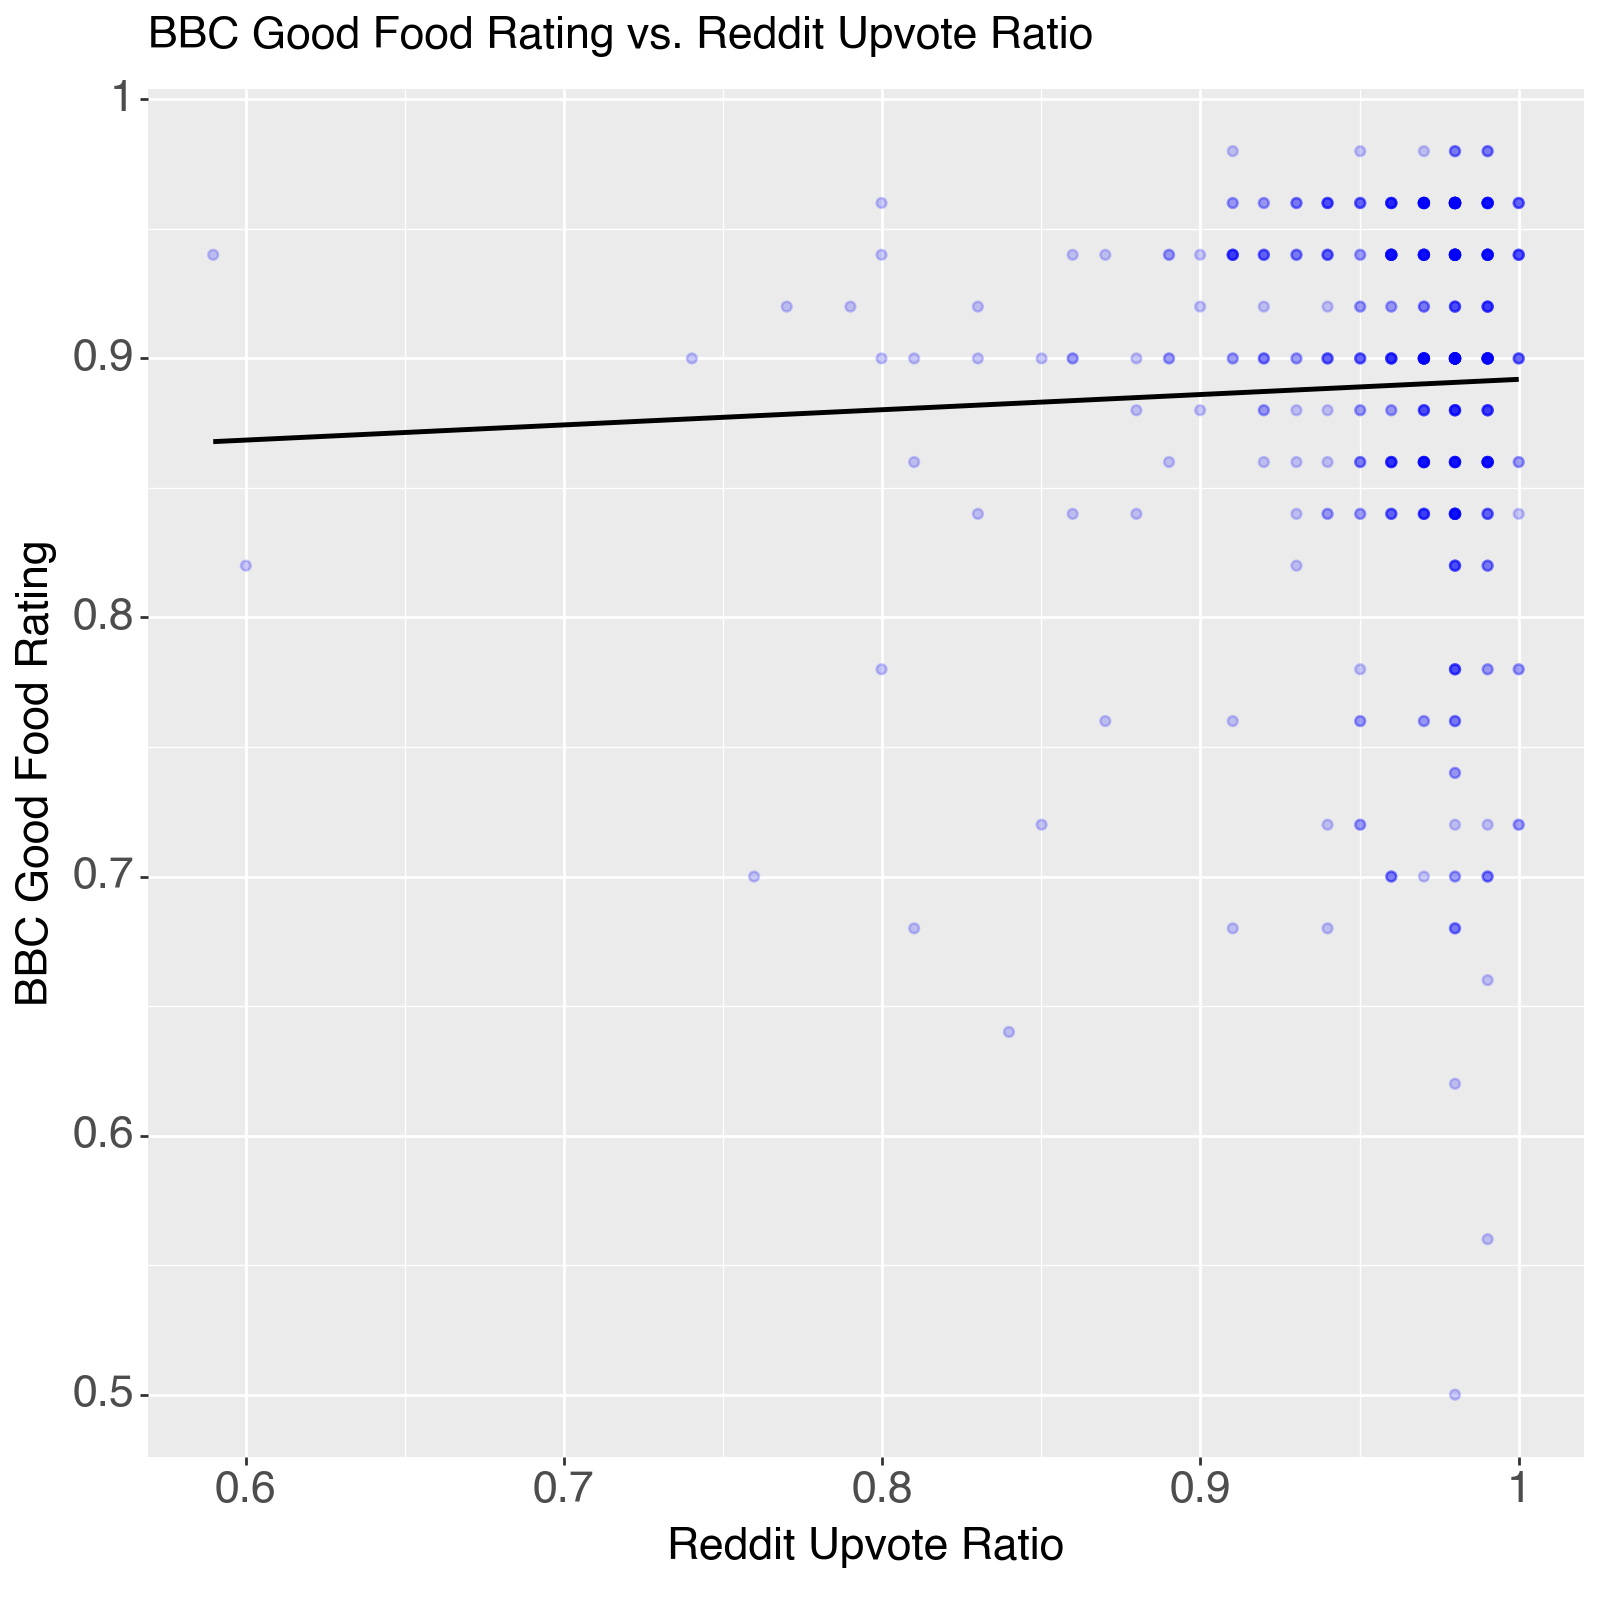

<Figure Size: (800 x 800)>

In [ ]:
# create a scatter plot of upvote ratio vs. bbc rating
plot = (
    ggplot(df_for_analysis, aes(x='upvote_ratio', y='bbcgf_ratings')) +
    geom_point(alpha=0.2, color='blue') +
    geom_smooth(method='lm', se=False) +
    labs(
        title='BBC Good Food Rating vs. Reddit Upvote Ratio',
        x='Reddit Upvote Ratio',
        y='BBC Good Food Rating'
    ) +
    theme(
        text=element_text(size=16),
        figure_size=(8, 8)
    )
)

plot 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


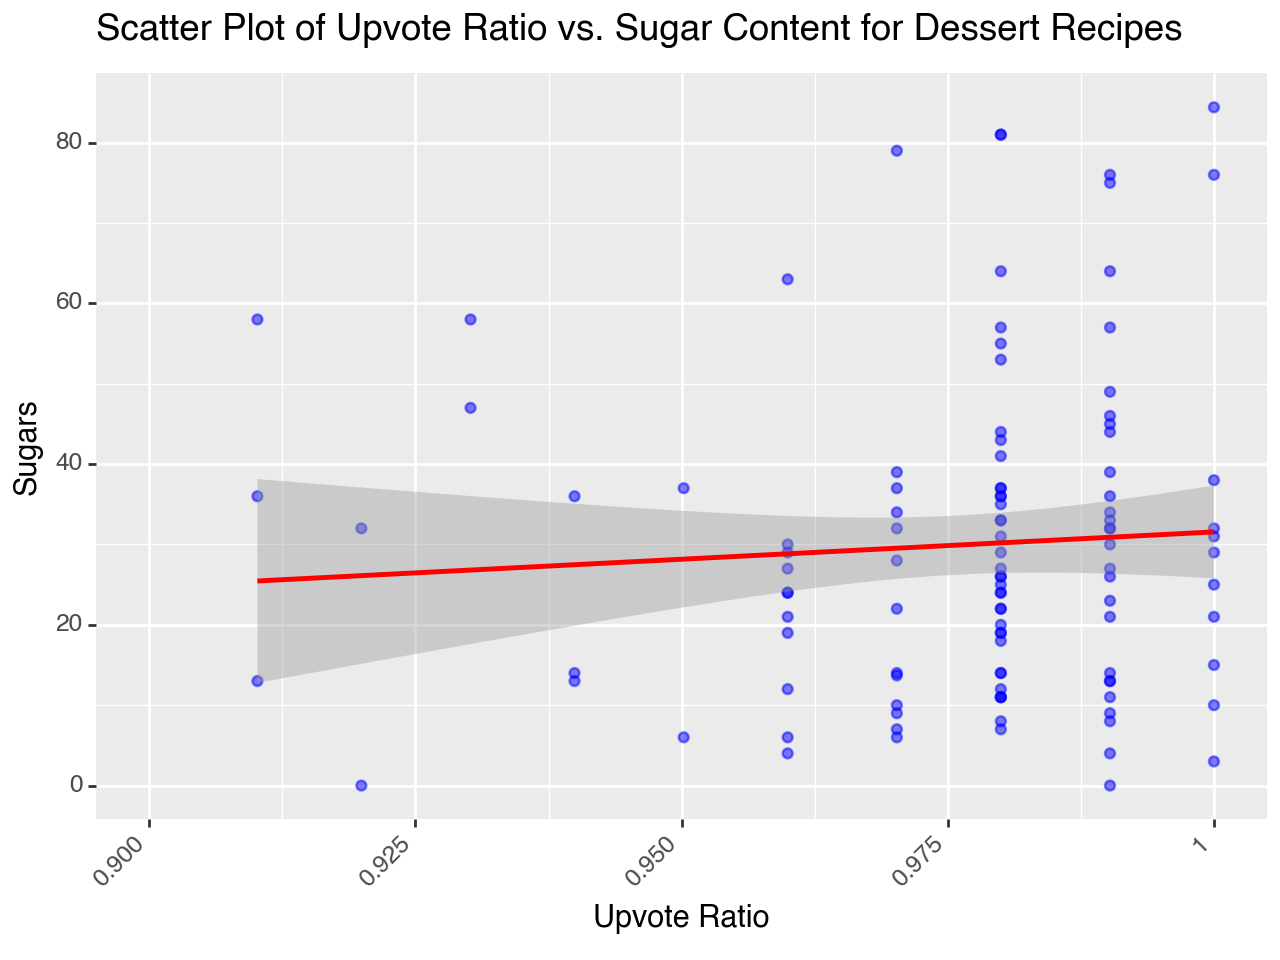

In [ ]:
plot = (
    ggplot(df_desserts, aes(x='upvote_ratio', y='sugars')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Upvote Ratio vs. Sugar Content for Dessert Recipes', x='Upvote Ratio', y='Sugars') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + xlim(0.9, 1)
)

print(plot)

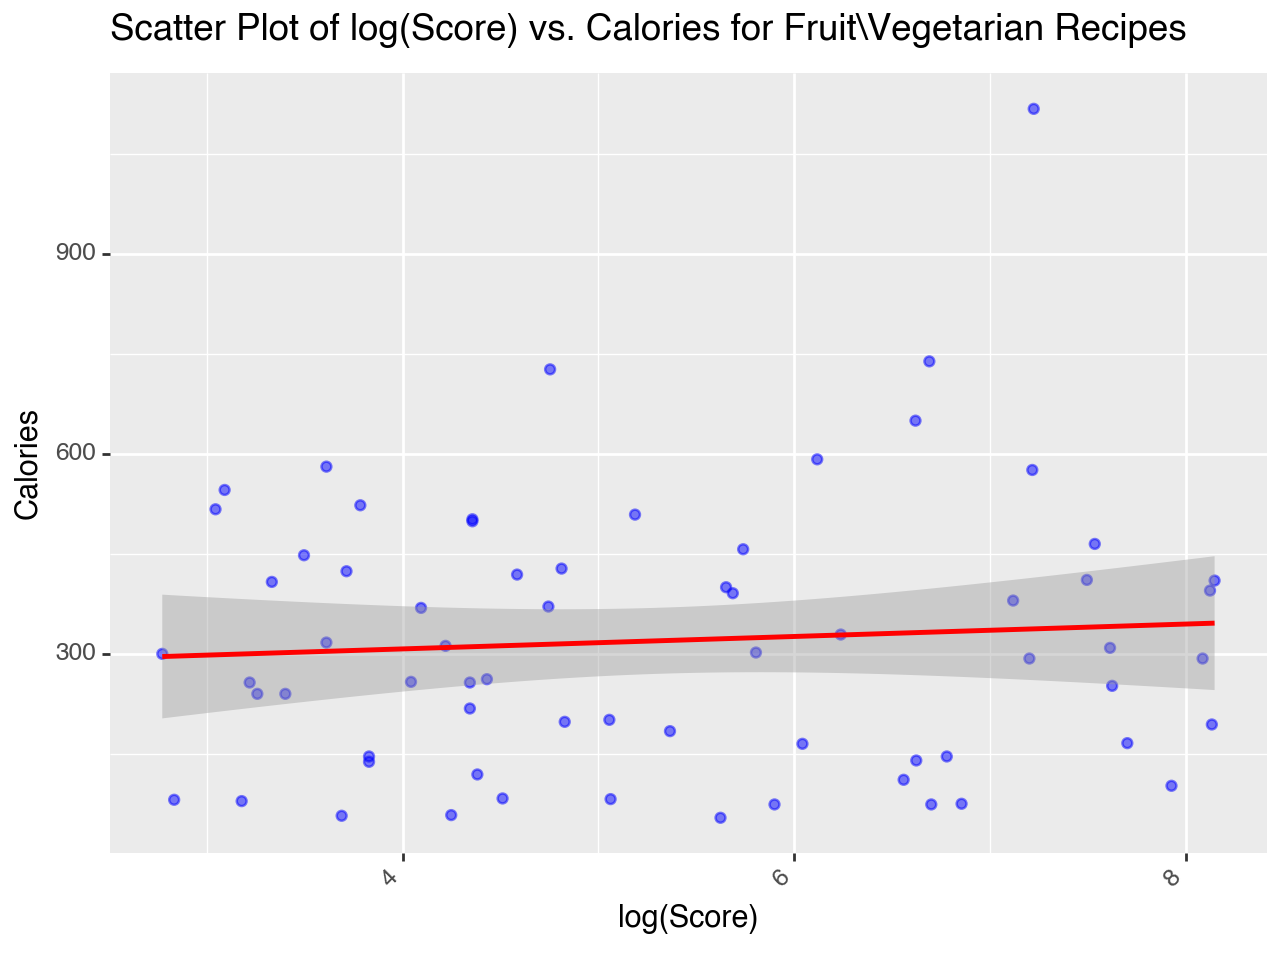

In [ ]:
plot = (
    ggplot(df_fruitveg, aes(x=np.log(df_fruitveg['score']), y='calories')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of log(Score) vs. Calories for Fruit\Vegetarian Recipes', x='log(Score)', y='Calories') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

print(plot)


/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 22 rows containing missing values.


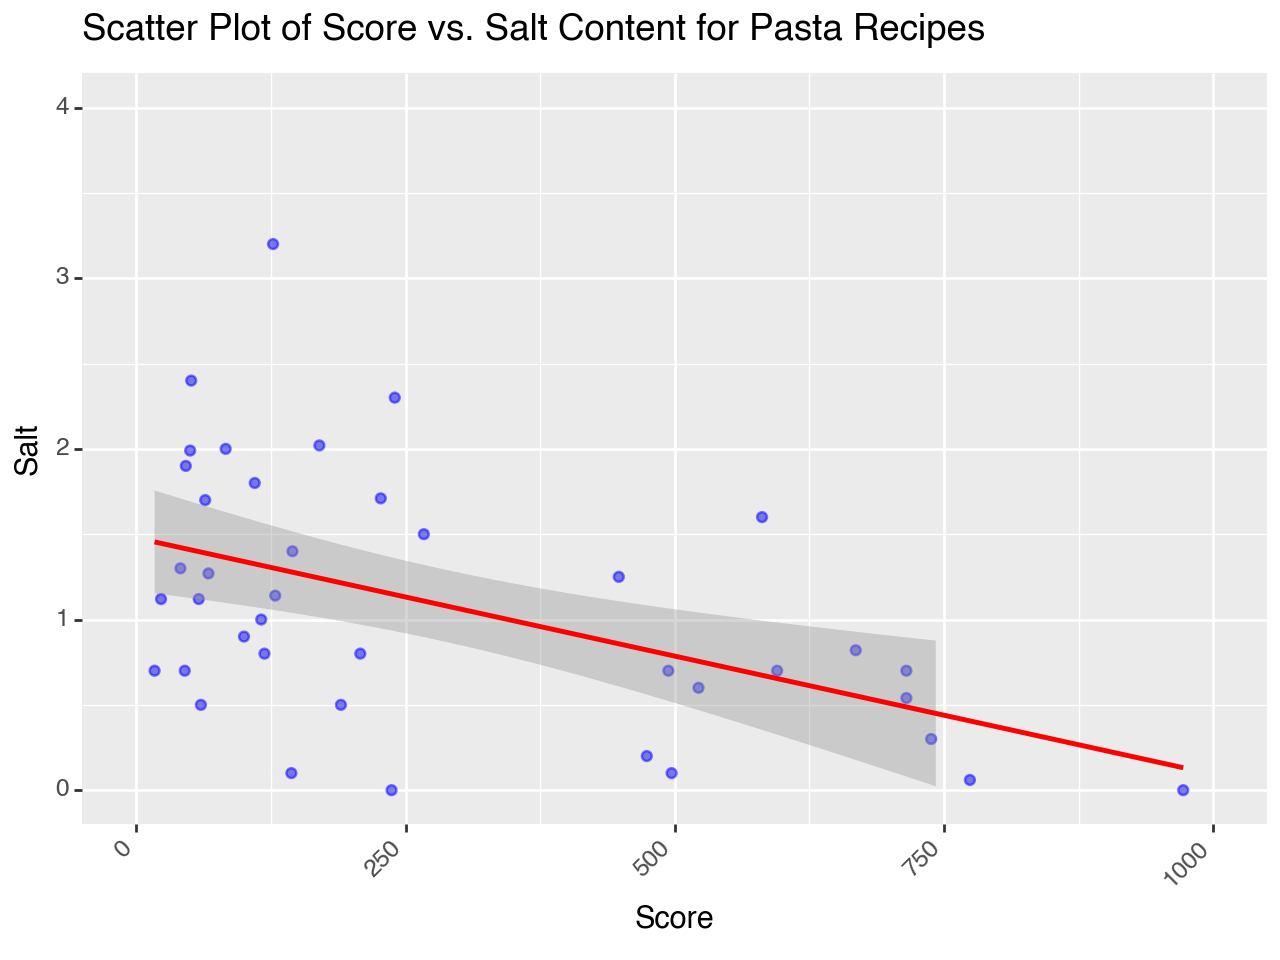

In [ ]:
plot = (
    ggplot(df_pasta, aes(x='score', y='salt')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Score vs. Salt Content for Pasta Recipes', x='Score', y='Salt') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + xlim(0, 1000)
    + ylim(0, 4)
)

print(plot)